In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsM_0041.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(403,370)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (82.16609642, 42.44354149)>


In [3]:
x = [82.150936,82.110034,82.158453,82.197666,82.182192,82.192476,82.113757,82.104471,82.095256,82.125836]
y = [42.449436,42.452321,42.478781,42.42245,42.480211,42.437444,42.478844,42.440872,42.420703,42.407897]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\2I Reduced')
file = 'reduceducdM_0041.fits'
image = pf.getdata(file)

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[468.50902635 641.97399634 437.87193548 269.25935595 337.36864778
 291.92433316 627.21984389 665.11558428 703.42317547 573.25174591]
[337.73248332 322.6181987  168.95299444 490.9287277  159.85225859
 405.03215735 170.18960111 388.55152008 504.67891281 577.15765306]
 id xcentroid ycentroid sharpness  ... sky    peak     flux      mag    
--- --------- --------- ---------- ... --- --------- -------- ----------
106 466.58055  333.5677 0.62351031 ...   0 165.94601 5.163085 -1.7822732
 id xcentroid ycentroid sharpness  ... sky   peak      flux      mag    
--- --------- --------- ---------- ... --- -------- --------- ----------
101 641.94174 318.91451 0.66076761 ...   0 83.58662 2.7412463 -1.0948702
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
 51 437.50776  167.3152 0.48838316 ...   0 971.29798 34.632662 -3.8487147
 id xcentroid ycentroid sharpness ... sky    peak      flux      mag    
-

In [44]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=4) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

In [45]:
mags.remove(mags[0])
mags.remove(mags[0])
mags.remove(mags[0])
mags.remove(mags[0])
magserrors.remove(magserrors[0])
magserrors.remove(magserrors[0])
magserrors.remove(magserrors[0])
magserrors.remove(magserrors[0])

Beta: [  0.39037666 -16.66807524]
Beta Std Error: [0.05652095 0.73445112]
Beta Covariance: [[ 0.03148434 -0.40524461]
 [-0.40524461  5.31620238]]
Residual Variance: 0.10146687521479848
Inverse Condition #: 0.05207011989639584
Reason(s) for Halting:
  Sum of squares convergence


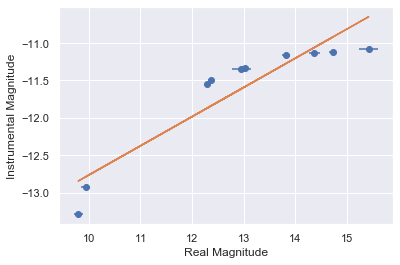

In [10]:
mags = np.array(mags)
Vmag = [15.758,16.402,13.119,15.872,13.806,10.272,12.923,14.323,11.868,14.98]
Vmag = np.array(Vmag)
Vmagerrors = [0.036,0.054,0.037,0.041,0.057,0.041,0.049,0.063,0.058,0.066]


rprime = [15.226,15.971,12.940,15.474,13.608,10.316,12.843,13.891,11.167,14.691]
rprimeerror = [0.13,0.15,0.026,0.068,0.046,0.033,0.027,0.041,0.033,0.071]

iprime = [14.84,15.842,12.726,15.178,13.39,10.326,12.771,13.502,10.349,14.299]
iprimeerror = [0.09,0.15,0.026,0.052,0.15,0.074,0.054,0.067,0.07,0.062,0.043]

Imag = []
Imagerror = []
for rp, ip, rperror, iperror in zip(rprime,iprime,rprimeerror,iprimeerror):
    r = rp +0.035*(rp-ip-0.21)
    rdrp = 1.035
    rdip = -0.035
    rerror = np.sqrt((rdrp**2)*rperror**2+(rdip**2)*iperror**2)
    
    i = ip + 0.041*(rp-ip-0.21)
    idrp = 0.041
    idip = 0.959
    ierror = np.sqrt((idrp**2)*rperror**2+(idip**2)*iperror**2)
    
   
    I = r-1.2444*(r-i)-0.382
    dr = -0.2444
    di = -1.2444
    Ierror = np.sqrt((dr**2)*(rerror**2)+(di**2)*(ierror**2))
    
    Imag.append(I)
    Imagerror.append(Ierror)
Imag = np.array(Imag)
Imagerror = np.array(Imagerror)



plt.errorbar(Imag,mags,xerr=Imagerror,yerr=magserrors,fmt='o')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(Imag, mags, sx = Imagerror, sy = None)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*Imag+myoutput.beta[1]
plt.plot(Imag,y)
myoutput.pprint()

Beta: [  0.53453805 -18.33202085]
Beta Std Error: [0.05088053 0.61492156]
Beta Covariance: [[ 0.06873581 -0.82376813]
 [-0.82376813 10.03966586]]
Residual Variance: 0.03766345689455313
Inverse Condition #: 0.04647187079689161
Reason(s) for Halting:
  Sum of squares convergence
[12.95506053  9.93710139 12.36554284 13.03252989  9.79290037 13.82892408]


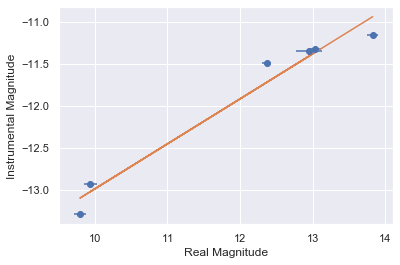

In [46]:
mags = np.array(mags)
Vmag = [13.806,10.272,12.923,14.323,11.868,14.98]
Vmag = np.array(Vmag)
Vmagerrors = [0.057,0.041,0.049,0.063,0.058,0.066]


rprime = [13.608,10.316,12.843,13.891,11.167,14.691]
rprimeerror = [0.046,0.033,0.027,0.041,0.033,0.071]

iprime = [13.39,10.326,12.771,13.502,10.349,14.299]
iprimeerror = [0.15,0.074,0.054,0.067,0.07,0.062,0.043]

Imag = []
Imagerror = []
for rp, ip, rperror, iperror in zip(rprime,iprime,rprimeerror,iprimeerror):
    r = rp +0.035*(rp-ip-0.21)
    rdrp = 1.035
    rdip = -0.035
    rerror = np.sqrt((rdrp**2)*rperror**2+(rdip**2)*iperror**2)
    
    i = ip + 0.041*(rp-ip-0.21)
    idrp = 0.041
    idip = 0.959
    ierror = np.sqrt((idrp**2)*rperror**2+(idip**2)*iperror**2)
    
   
    I = r-1.2444*(r-i)-0.382
    dr = -0.2444
    di = -1.2444
    Ierror = np.sqrt((dr**2)*(rerror**2)+(di**2)*(ierror**2))
    
    Imag.append(I)
    Imagerror.append(Ierror)
Imag = np.array(Imag)
Imagerror = np.array(Imagerror)



plt.errorbar(Imag,mags,xerr=Imagerror,yerr=magserrors,fmt='o')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(Imag, mags, sx = Imagerror, sy = None)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*Imag+myoutput.beta[1]
plt.plot(Imag,y)
myoutput.pprint()
print(Imag)

In [47]:
xref = 416
yref = 404

mean, median, std = sigma_clipped_stats(image, sigma=5)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
196 299.08825 635.74589 0.50173278 ...   0 17.404293 1.1723671 -0.17265902
121 413.90821   403.067 0.55137947 ...   0   43326.6 1453.4587  -7.9060067
121 413.90821   403.067 0.55137947 ...   0   43326.6 1453.4587  -7.9060067
121 413.90821   403.067 0.55137947 ...   0   43326.6 1453.4587  -7.9060067
121 413.90821   403.067 0.55137947 ...   0   43326.6 1453.4587  -7.9060067
121 413.90821   403.067 0.55137947 ...   0   43326.6 1453.4587  -7.9060067


In [48]:
sourcemag = []
sourcemagerror = []
position = [(413.90821,403.067)]
aperture = CircularAperture(position[0], r=4) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-14.469439970862105]


In [49]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

7.226016695374969 +/- 1.3403244343333631
